# Session 6: Autoregressive Music Generation

Agenda
- Overview of the Transformer model
- Understanding Anticipatory Music Transformers
- Understanding MusicGen
- Hands On 1: Using AMT to generate MIDI data
- Hands On 2: Using MusicGen to generate audio

## The Transformer architecture

From the paper [Attention Is All You Need (Vaswani et al., 2017)](https://arxiv.org/abs/1706.03762).

![](./assets/transformer.png)

## Understanding Anticipatory Music Transformers

From the papers [Music Transformer (Huang et al., 2018)](https://arxiv.org/abs/1809.04281) and [Anticipatory Music Transformers (Thickstun et al., 2023)](https://arxiv.org/abs/2306.08620).

![](./assets/music_transformer.png)

## Understanding MusicGen

From the paper [Simple and Controllable Music Generation (Copet et al., 2023)](https://arxiv.org/abs/2306.05284).

![](./assets/musicgen.png)

# Hands On 1: Using AMT to generate MIDI Data

In [ ]:
# Clone the anticipation repository
!git clone https://github.com/lancelotblanchard/anticipation.git ../repositories/anticipation

In [27]:
import os
os.environ["HF_HUB_CACHE"] = os.path.abspath("../huggingface_hub_cache/")

from transformers import GPT2LMHeadModel

# set Hub Cache folder
model = GPT2LMHeadModel.from_pretrained("stanford-crfm/music-small-800k", attn_implementation="eager")

In [4]:
# Add our repository to the Python path

import sys
sys.path.append('../repositories/anticipation')

In [117]:
from anticipation import ops
from anticipation.config import MAX_INSTR, MAX_PITCH
from anticipation.vocab import ANTICIPATE, CONTROL_OFFSET, DUR_OFFSET, NOTE_OFFSET, TIME_OFFSET
from anticipation.sample import nucleus
import torch

# Let's look at generating some tokens unconditionally. Before we can do so,
# we need to look at building an inference function:

def generate_note(model, tokens, current_time, active_instruments, top_p=0.98, history_length=340, monophony=False):
    assert len(tokens) % 3 == 0 # we need to have a valid sequence

    history = tokens.copy()
    lookback = max(len(tokens) - 3*history_length, 0)
    history = history[lookback:]
    offset = ops.min_time(history, seconds=False)
    history[::3] = [tok - offset for tok in history[::3]] # Relative time

    new_tokens = []
    with torch.no_grad():
        for i in range(3):
            # Create the input sequence
            input_sequence = torch.tensor([ANTICIPATE] + history + new_tokens).unsqueeze(0).to(model.device)
            logits = model(input_sequence).logits[0, -1]

            # Filter the logits.
            # 1. Do not generate controls
            logits[CONTROL_OFFSET:] = -float('inf')

            # 2. For times, generate correct times that are not in the past
            if i == 0:
                logits[DUR_OFFSET:CONTROL_OFFSET] = -float('inf')
                if current_time > 0:
                    logits[TIME_OFFSET:TIME_OFFSET+current_time+(1 if monophony else 0)] = -float('inf')


            # 3. Generate correct durations
            elif i == 1:
                logits[TIME_OFFSET:DUR_OFFSET] = -float('inf')
                logits[NOTE_OFFSET:CONTROL_OFFSET] = -float('inf')

            # 4. Generate correct notes, and only generate instruments that are active
            elif i == 2:
                logits[TIME_OFFSET:NOTE_OFFSET] = -float('inf')
                active_instruments = sorted(active_instruments)
                # Filter up to lowest note of first active instrument
                logits[NOTE_OFFSET:NOTE_OFFSET + active_instruments[0]*MAX_PITCH] = -float('inf')
                # Filter between active instruments
                for j in range(len(active_instruments) - 1):
                    logits[NOTE_OFFSET + (active_instruments[j]+1)*MAX_PITCH:NOTE_OFFSET + active_instruments[j+1]*MAX_PITCH] = -float('inf')
                # Filter after highest note of last active instrument
                logits[NOTE_OFFSET + (active_instruments[-1]+1)*MAX_PITCH:] = -float('inf')

            # Sample from the logits (with Nucleus sampling)
            logits = nucleus(logits, top_p=top_p)
            probs = torch.nn.functional.softmax(logits, dim=-1)
            new_token = torch.multinomial(probs, 1).item()
            new_tokens.append(new_token)
        
    new_tokens[0] += offset # Revert back to regular time

    return new_tokens

In [38]:
# Let's try to generate a few notes

tokens = []
current_time = 0
for i in range(40):
    new_tokens = generate_note(model, tokens, current_time, active_instruments=[1])
    print(new_tokens)
    tokens += new_tokens
    current_time = new_tokens[0]

[0, 10010, 11197]
[0, 10010, 11200]
[0, 10013, 11200]
[0, 10014, 11209]
[26, 10014, 11199]
[26, 10012, 11202]
[26, 10014, 11199]
[26, 10015, 11207]
[51, 10011, 11200]
[51, 10011, 11204]
[51, 10012, 11200]
[51, 10013, 11204]
[51, 10015, 11195]
[51, 10014, 11204]
[101, 10010, 11200]
[101, 10011, 11204]
[101, 10011, 11200]
[101, 10014, 11195]
[101, 10013, 11204]
[152, 10012, 11202]
[152, 10013, 11205]
[152, 10014, 11202]
[152, 10015, 11197]
[152, 10015, 11205]
[203, 10012, 11202]
[203, 10015, 11205]
[203, 10015, 11202]
[203, 10015, 11197]
[203, 10016, 11205]
[255, 10014, 11202]
[255, 10014, 11205]
[255, 10013, 11202]
[255, 10014, 11197]
[255, 10014, 11205]
[307, 10019, 11202]
[307, 10021, 11205]
[307, 10024, 11202]
[307, 10024, 11197]
[307, 10026, 11205]
[332, 10010, 11195]


In [39]:
from anticipation.convert import events_to_midi
import midi2audio
import librosa
from IPython.display import Audio

# Let's listen to our sequence of tokens

# We first need to convert our tokens to a MIDI file
events_to_midi(tokens).save("assets/generation.mid")

midi2audio_obj = midi2audio.FluidSynth("../session2_setup/assets/soundfont.sf2")
midi2audio_obj.midi_to_audio("assets/generation.mid", "assets/generation.wav")

y, sr = librosa.load("assets/generation.wav", sr=44100)

display(Audio(y, rate=sr))

FluidSynth runtime version 2.3.5
Copyright (C) 2000-2024 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'assets/generation.wav'..


fluidsynth: panic: An error occurred while reading from stdin.
fluidsynth: panic: An error occurred while reading from stdin.


torch.Size([55028])


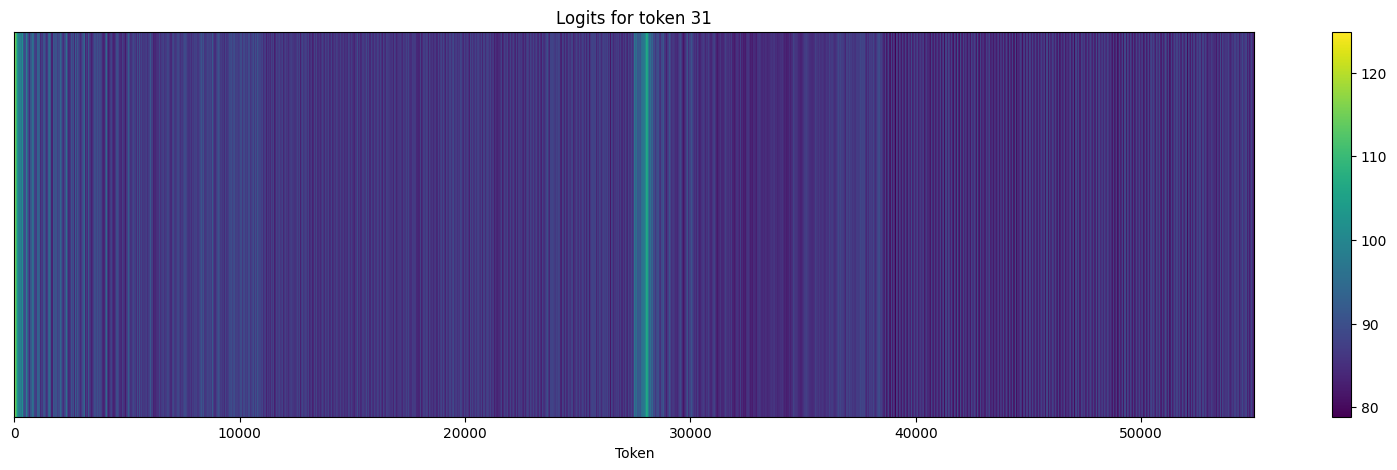

In [83]:
import matplotlib.pyplot as plt

# Let's take a look at what logits look like
tokens_subset = tokens[:3*10]
with torch.no_grad():
    input_sequence = torch.tensor([ANTICIPATE] + tokens_subset).unsqueeze(0).to(model.device)
    logits = model(input_sequence).logits[0, -1]

print(logits.shape)

plt.figure(figsize=(20, 5))
plt.imshow(logits.cpu().unsqueeze(0).numpy(), aspect='auto', interpolation='nearest')
plt.xlabel("Token")
plt.yticks([])
plt.title("Logits for token 31")
plt.colorbar()
plt.show()

Last time of the sequence is 51
New token would be sampled for 51


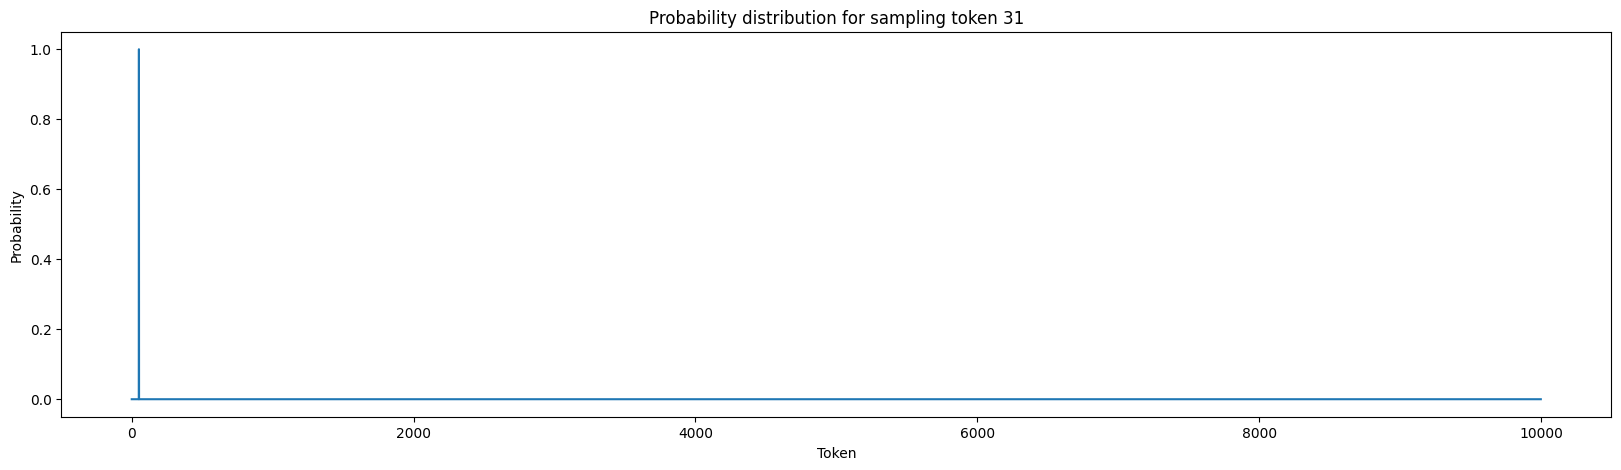

In [88]:
from anticipation.config import MAX_TIME

# Let's do the same thing after nucleus sampling processing

print(f"Last time of the sequence is {tokens_subset[-3]}")

# Safety filtering for time tokens
logits[DUR_OFFSET:] = -float('inf')
logits[TIME_OFFSET:TIME_OFFSET+tokens_subset[-3]] = -float('inf')

# Get the probability distribution of the new token
nucleus_logits = nucleus(logits, top_p=0.98)
probs = torch.nn.functional.softmax(nucleus_logits, dim=-1)
new_token = torch.multinomial(probs, 1).item()

print(f"New token would be sampled for {new_token}")

plt.figure(figsize=(20, 5))
plt.plot(probs[:MAX_TIME].cpu().numpy())
plt.xlabel("Token")
plt.title("Probability distribution for sampling token 31")
plt.ylabel("Probability")

plt.show()

In [94]:
from anticipation.convert import midi_to_events

# Let's now work with a conditioning signal! We'll convert our MIDI file to tokens

symphony40 = midi_to_events("../session2_setup/assets/symphony40.mid")
print(f"Number of tokens: {len(symphony40)}, number of notes: {len(symphony40)//3}")
print(f"First tokens: {symphony40[:6]}")

Number of tokens: 38085, number of notes: 12695
First tokens: [126, 10016, 16175, 126, 10016, 16178]


In [95]:
# We can calculate the number of instruments by looking at the tokens

instruments = set()
for note in symphony40[2::3]:
    instruments.add((note - NOTE_OFFSET) // MAX_PITCH)

print(f"Number of instruments: {len(instruments)}")
print(f"Instruments: {instruments}")

Number of instruments: 4
Instruments: {40, 73, 42, 60}


In [110]:
# Let's filter the first 238 notes of the sequence and only keep instrument 42
# We will also keep the notes of instrument 40 as a ground truth

control_tokens = []
ground_truth = []
for t, d, n in zip(symphony40[:238*3:3], symphony40[1:238*3:3], symphony40[2:238*3:3]):
    if (n - NOTE_OFFSET) // MAX_PITCH == 42:
        control_tokens += [t, d, n]
        ground_truth += [t, d, n]
    if (n - NOTE_OFFSET) // MAX_PITCH == 40:
        ground_truth += [t, d, n]

events_to_midi(control_tokens).save("assets/control.mid")
midi2audio_obj.midi_to_audio("assets/control.mid", "assets/control.wav")

y, sr = librosa.load("assets/control.wav", sr=44100)

display(Audio(y, rate=sr))

FluidSynth runtime version 2.3.5
Copyright (C) 2000-2024 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'assets/control.wav'..


fluidsynth: panic: An error occurred while reading from stdin.
fluidsynth: panic: An error occurred while reading from stdin.


In [118]:
from anticipation.config import DELTA
import math

# We will use this sequence as a conditioning signal for our generation
# Let's generate instrument 42 with the given control signal

# First, let's add CONTROL_OFFSET to the control tokens
anticipated_control_tokens = [CONTROL_OFFSET + t for t in control_tokens]

# We select the first control token and leave the rest for later
atime, adur, anote = anticipated_control_tokens[0:3]
atokens = anticipated_control_tokens[3:]
# This is the time of the first control
anticipated_time = atime - CONTROL_OFFSET

# We will generate until end time
end_time = max(control_tokens[::3])
current_time = 0
conditioned_tokens = []

# Generation loop
while current_time < end_time:
    # Anticipated if needed
    while current_time >= anticipated_time - DELTA:
        conditioned_tokens.extend([atime, adur, anote])

        if len(atokens) > 0:
            atime, adur, anote = atokens[0:3]
            atokens = atokens[3:]
            anticipated_time = atime - CONTROL_OFFSET
        else:
            anticipated_time = math.inf

    new_tokens = generate_note(model, conditioned_tokens, current_time, active_instruments=[40], monophony=True)
    print(new_tokens)
    conditioned_tokens += new_tokens
    current_time = new_tokens[0]

# We remove the control tokens and add them without CONTROL_OFFSET
conditioned_tokens, _ = ops.split(conditioned_tokens)
conditioned_tokens = ops.sort(conditioned_tokens + control_tokens)

[0, 10025, 16186]
[0, 10026, 16182]
[12, 10013, 16191]
[25, 10025, 16187]
[37, 10013, 16196]
[50, 10013, 16194]
[62, 10012, 16192]
[75, 10012, 16191]
[87, 10012, 16192]
[100, 10012, 16194]
[112, 10012, 16191]
[125, 10012, 16187]
[150, 10026, 16201]
[151, 10025, 16192]
[175, 10026, 16199]
[176, 10025, 16191]
[200, 10025, 16198]
[201, 10025, 16189]
[225, 10013, 16199]
[226, 10052, 16191]
[237, 10013, 16203]
[250, 10013, 16206]
[273, 10030, 16206]
[302, 10024, 16206]
[324, 10025, 16206]
[350, 10027, 16199]
[351, 10025, 16191]
[375, 10027, 16198]
[400, 10027, 16196]
[426, 10052, 16194]
[450, 10013, 16198]
[463, 10013, 16201]
[475, 10050, 16206]
[502, 10026, 16192]
[527, 10052, 16191]
[552, 10013, 16194]
[565, 10013, 16199]
[577, 10051, 16203]
[603, 10026, 16189]
[628, 10053, 16187]
[650, 10014, 16191]
[664, 10015, 16194]
[679, 10052, 16199]
[706, 10026, 16182]
[731, 10053, 16180]
[756, 10014, 16192]
[1028, 10030, 16201]
[1054, 10027, 16189]
[1079, 10027, 16192]
[1106, 10024, 16198]
[1130, 

In [119]:
# We can now listen to our result

events_to_midi(conditioned_tokens).save("assets/conditioned_generation.mid")

midi2audio_obj = midi2audio.FluidSynth("../session2_setup/assets/soundfont.sf2")
midi2audio_obj.midi_to_audio("assets/conditioned_generation.mid", "assets/conditioned_generation.wav")

y, sr = librosa.load("assets/conditioned_generation.wav", sr=44100)

display(Audio(y, rate=sr))

FluidSynth runtime version 2.3.5
Copyright (C) 2000-2024 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'assets/conditioned_generation.wav'..


fluidsynth: panic: An error occurred while reading from stdin.
fluidsynth: panic: An error occurred while reading from stdin.


## Hands On 2: Using MusicGen to generate audio

In [1]:
import os
os.environ["HF_HUB_CACHE"] = os.path.abspath("../huggingface_hub_cache")

from transformers import MusicgenMelodyForConditionalGeneration, MusicgenMelodyProcessor
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = MusicgenMelodyProcessor.from_pretrained("facebook/musicgen-melody")
model = MusicgenMelodyForConditionalGeneration.from_pretrained("facebook/musicgen-melody")
model = model.to(device)

/Users/lancelotblanchard/Desktop/MediaLabMAS/Teaching/Music Hackspace/lectures/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 15.93it/s]


In [2]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                                      Param #
MusicgenMelodyForConditionalGeneration                                      --
├─T5EncoderModel: 1-1                                                       --
│    └─Embedding: 2-1                                                       24,674,304
│    └─T5Stack: 2-2                                                         24,674,304
│    │    └─Embedding: 3-1                                                  (recursive)
│    │    └─ModuleList: 3-2                                                 84,953,472
│    │    └─T5LayerNorm: 3-3                                                768
│    │    └─Dropout: 3-4                                                    --
├─EncodecModel: 1-2                                                         --
│    └─EncodecEncoder: 2-3                                                  --
│    │    └─ModuleList: 3-5                                                 28,441,984
│    

In [3]:
# We can first generate unconditional music
unconditional_inputs = processor.get_unconditional_inputs(num_samples=1).to(model.device)

unconditional_audio_values = model.generate(**unconditional_inputs, max_new_tokens=512)

In [5]:
from IPython.display import Audio, display

# Let's listen to our audio

display(Audio(unconditional_audio_values.squeeze(0, 1).cpu(), rate=model.config.sampling_rate))

In [6]:
# We can also generate a piece of music conditionally, with a given text prompt

text_conditioned_inputs = processor(
    text=["80s pop track with bassy drums and synth"],
    padding=True,
    return_tensors="pt",
).to(model.device)

text_conditioned_audio_values = model.generate(**text_conditioned_inputs, guidance_scale=3, max_new_tokens=512)

display(Audio(text_conditioned_audio_values.squeeze(0, 1).cpu(), rate=model.config.sampling_rate))

In [7]:
import librosa
from IPython.display import Audio

# And we can also generate with a melody condition, passed as an audio array

y, sr = librosa.load("bolero_ravel.mp3", sr=model.config.sampling_rate)

display(Audio(y, rate=sr))

melody_conditioned_inputs = processor(
    audio=y,
    sampling_rate=model.config.sampling_rate,
    text=["90s rock song with loud guitars and heavy drums"],
    padding=True,
    return_tensors="pt",
).to(model.device)

melody_conditioned_audio_values = model.generate(**melody_conditioned_inputs, guidance_scale=3, max_new_tokens=512)

display(Audio(melody_conditioned_audio_values.squeeze(0, 1).cpu(), rate=model.config.sampling_rate))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [8]:
# Let's take a look at how this model actually generates music

# ############### #
# 0. CONDITIONING # 
# ############### #

text_prompt = processor.tokenizer("90s rock song with loud guitars and heavy drums", return_tensors="pt")
inputs_tensor = text_prompt["input_ids"].to(model.device)
attention_mask = text_prompt["attention_mask"].to(model.device)

print(inputs_tensor)
print(attention_mask)

# Then, we get our melody conditioning (a chroma spectrogram)
melody_prompt = processor.feature_extractor(y, sampling_rate=model.config.sampling_rate, return_tensors="pt")
input_features = melody_prompt["input_features"].to(model.device)

print(melody_prompt["input_features"].shape)

tensor([[2777,    7, 2480, 2324,   28, 8002, 5507,    7,   11, 2437, 5253,    7,
            1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
torch.Size([1, 79, 12])


In [9]:
import copy

# ################# #
# 1. PREPARE CONFIG #
# ################# #

generation_config = copy.deepcopy(model.generation_config)
model._prepare_special_tokens(generation_config, device=model.device)

In [10]:
import math

# #################### #
# 2. TEXT CONDITIONING #
# #################### #

encoder = model.get_text_encoder()
with torch.no_grad():
    encoder_hidden_states = encoder(
        input_ids=inputs_tensor,
        attention_mask=attention_mask,
        output_attentions=generation_config.output_attentions,
        output_hidden_states=generation_config.output_hidden_states,
        return_dict=True,
    ).last_hidden_state

# project encoder_hidden_states
encoder_hidden_states = model.enc_to_dec_proj(encoder_hidden_states)

# for classifier free guidance we need to add a 'null' input to our encoder hidden states
encoder_hidden_states = torch.concatenate(
    [encoder_hidden_states, torch.zeros_like(encoder_hidden_states)], dim=0
)
encoder_attention_mask = torch.concatenate(
    [attention_mask, torch.zeros_like(attention_mask)], dim=0
)
encoder_hidden_states = encoder_hidden_states * encoder_attention_mask[..., None]

In [11]:
# ##################### #
# 3. AUDIO CONDITIONING #
# ##################### #

null_audio_hidden_states = torch.zeros_like(input_features)
null_audio_hidden_states[:, :, 0] = 1

# for classifier free guidance we need to add a 'null' input to our audio hidden states
audio_hidden_states = torch.concatenate([input_features, null_audio_hidden_states], dim=0)

# project audio_hidden_states ->
# (batch_size, seq_len, num_chroma) -> (batch_size, seq_len, hidden_size)
audio_hidden_states = model.audio_enc_to_dec_proj(audio_hidden_states)

# pad or truncate to config.chroma_length
n_repeat = int(math.ceil(model.config.chroma_length / audio_hidden_states.shape[1]))
audio_hidden_states = audio_hidden_states.repeat(1, n_repeat, 1)

audio_hidden_states = audio_hidden_states[:, : model.config.chroma_length]

encoder_hidden_states = torch.cat([audio_hidden_states, encoder_hidden_states], dim=1)

In [12]:
# ##################################### #
# 4. PREPARE AUTO-REGRESSIVE GENERATION #
# ##################################### #

input_ids = torch.tensor([
    [2048],
    [2048],
    [2048],
    [2048]
], device=model.device)

In [13]:
# ###################### #
# 5. BUILD DELAY PATTERN #
# ###################### #

max_length = 513

input_ids, decoder_delay_pattern_mask = model.decoder.build_delay_pattern_mask(
    input_ids,
    pad_token_id=generation_config._decoder_start_token_tensor,
    max_length=max_length,
)
print(decoder_delay_pattern_mask.shape)
print(decoder_delay_pattern_mask)

torch.Size([4, 513])
tensor([[2048,   -1,   -1,  ..., 2048, 2048, 2048],
        [2048, 2048,   -1,  ...,   -1, 2048, 2048],
        [2048, 2048, 2048,  ...,   -1,   -1, 2048],
        [2048, 2048, 2048,  ...,   -1,   -1,   -1]])


In [14]:
from transformers import ClassifierFreeGuidanceLogitsProcessor, LogitsProcessorList, TopKLogitsWarper

# ########################### #
# 6. PREPARE LOGITS PROCESSOR #
# ########################### #

guidance_scale = 3

logits_processor = LogitsProcessorList()
logits_processor.append(ClassifierFreeGuidanceLogitsProcessor(guidance_scale))
logits_processor.append(TopKLogitsWarper(top_k=generation_config.top_k, min_tokens_to_keep=1))

In [15]:
from transformers import StoppingCriteriaList, MaxLengthCriteria

# ############################ #
# 7. PREPARE STOPPING CRITERIA #
# ############################ #

stopping_criteria = StoppingCriteriaList()
stopping_criteria.append(MaxLengthCriteria(max_length=max_length))

In [16]:
# #################### #
# 8. RUN SAMPLING LOOP #
# #################### #

with torch.no_grad():
    outputs = model._sample(
        input_ids,
        logits_processor=logits_processor,
        stopping_criteria=stopping_criteria,
        generation_config=generation_config,
        use_cache=True,
        guidance_scale=3,
        input_features=input_features,
        encoder_hidden_states=encoder_hidden_states,
        decoder_delay_pattern_mask=decoder_delay_pattern_mask,
        synced_gpus=None,
        streamer=None,
    )

In [17]:
# ################ #
# 9. DECODE OUTPUT #
# ################ #

# apply the pattern mask to the final ids
output_ids = model.decoder.apply_delay_pattern_mask(outputs, decoder_delay_pattern_mask)

# revert the pattern delay mask by filtering the pad token id
output_ids = output_ids[output_ids != generation_config._pad_token_tensor].reshape(
    1, model.decoder.num_codebooks, -1
)

# append the frame dimension back to the audio codes
output_ids = output_ids[None, ...]

with torch.no_grad():
    output_values = model.audio_encoder.decode(
        output_ids,
        audio_scales=[None],
    ).audio_values

In [18]:
# Do we get a similar output?

display(Audio(output_values.cpu().squeeze(0, 1), rate=model.config.sampling_rate))